[ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>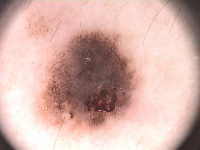</td><td>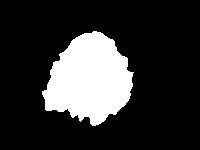</td></tr></table>


In [2]:
!wget https://www.dropbox.com/s/4q6kwg8de56eqnc/PH2Dataset.rar #https://www.dropbox.com/s/t0ichx42vg218hc/PH2Dataset.rar

--2021-12-14 05:48:41--  https://www.dropbox.com/s/4q6kwg8de56eqnc/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4q6kwg8de56eqnc/PH2Dataset.rar [following]
--2021-12-14 05:48:41--  https://www.dropbox.com/s/raw/4q6kwg8de56eqnc/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucad372452986bdd1a76be467a9c.dl.dropboxusercontent.com/cd/0/inline/BbyS4sVUwFXFpizk9gy-qmjxeLsKDfcvGr6yfU7VxTh374E8irlunnj7ufPYw2Dk_KPnoL6iqBh6RrskipdBVqy5-mwQWY0A93jmC_GUC02QhRpWzcBT-dyma5SpR7W9OIZV9Yqlb1-2iypYV01avADe/file# [following]
--2021-12-14 05:48:41--  https://ucad372452986bdd1a76be467a9c.dl.dropboxusercontent.com/cd/0/inline/BbyS4sVUwFXFpizk9gy-qmjxeLsKDfcvGr6yfU7VxTh374E8irlunnj7ufPYw2Dk_KPnoL6iqBh6RrskipdB

In [3]:
get_ipython().system_raw("unrar x PH2Dataset.rar")


In [4]:
!ls PH2Dataset

'PH2 Dataset images'   PH2_dataset.txt	 PH2_dataset.xlsx   Readme.txt




    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...



In [5]:
images = []
lesions = []
from skimage.io import imread
import os
path = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(path, 'PH2 Dataset images')): 
  
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [6]:
len(images[0])

576

In [7]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [8]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from torch.utils.data import DataLoader
import random 
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

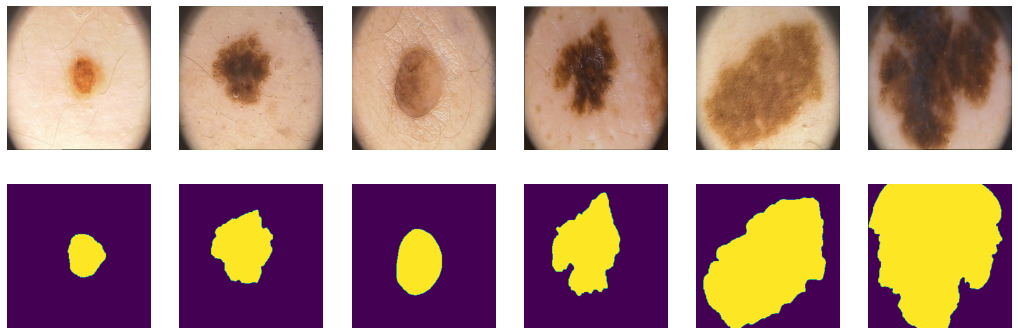

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [11]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [12]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [13]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [14]:
batch_size = 15
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda



# SegNet

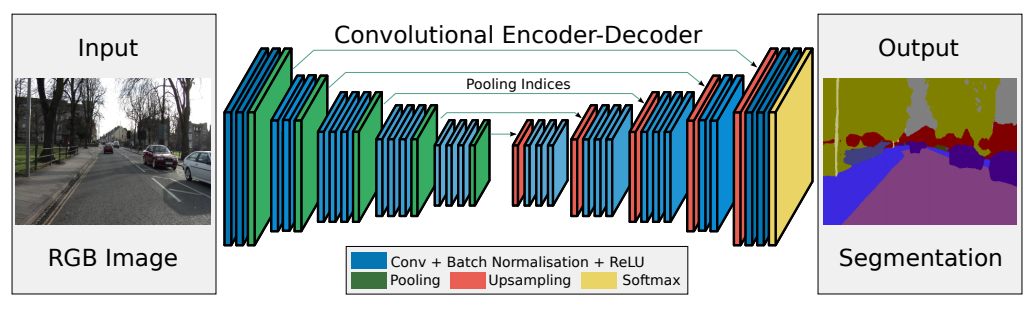

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [17]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64)
        ) # 256 -> 128
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2) #kernel_size=2, stride=2
          
        self.enc_conv1 = nn.Sequential(
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(128),
          nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3,stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(128)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(256),
          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(256),
          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(256)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
          nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(512)
        )

        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 =  nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 =  nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.upsample2 =  nn.Upsample(scale_factor=2) # 64 -> 128
        self.dec_conv2 =  nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.upsample3 =  nn.Upsample(scale_factor=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        # encoder
    
        e0 = self.enc_conv0(x)
        pooled_e0 = self.pool0(e0)
        
        e1 = self.enc_conv1(pooled_e0)
        pooled_e1 = self.pool1(e1)
       
        e2 = self.enc_conv2(pooled_e1)
        pooled_e2 = self.pool2(e2)
        
        e3 = self.enc_conv3(pooled_e2)
        pooled_e3 = self.pool3(e3)
        
        # bottleneck
        b = self.bottleneck_conv(pooled_e3)
        
        # decoder
        d0 = self.upsample0(b)
        upsampled_d0 = self.dec_conv0(d0)
        
        d1 = self.upsample0(upsampled_d0)
        upsampled_d1 = self.dec_conv1(d1)

        d2 = self.upsample0(upsampled_d1)
        upsampled_d2 = self.dec_conv2(d2)

        d3 =  self.upsample3(upsampled_d2)
        upsampled_d3 = self.dec_conv3(d3) # no activation
        return upsampled_d3

## Metric

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$




![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)



![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
   
    # BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte() 
    # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte() 
    SMOOTH = 1e-8
    intersection = (outputs & labels).sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    return  iou  

## Loss Function

Binary Cross Entropy

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$



$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [17]:
def bce_loss(y_pred, y_real):
    
    y_pred = torch.sigmoid(y_pred)
    losses = y_pred - y_real*y_pred + torch.log(1+torch.exp(-y_pred))
    return losses.mean()

## Train

In [18]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    train_history = []
    valid_history = []
    train_scores = []
    val_scores = []
    best_valid_loss = float('inf')

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        history = []
        train_loss = 0
        valid_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
          
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch.to(device))  
            
            # calculate loss to show the user
            t_loss = loss_fn(Y_pred, Y_batch.to(device)) # forward-pass
            train_loss += t_loss.item() 
            t_loss.backward()  # backward-pass
            opt.step()  # update weights
            
            train_score = score_model(model, iou_pytorch, data_tr)
            
            history.append(t_loss.cpu().data.numpy())
        toc = time()
        print('loss: %f' % train_loss)
        
        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
          
          Y_hat = model(X_val.to(device)) > 0 
          v_loss = loss_fn(Y_hat, Y_val.to(device)).cpu().numpy()
          valid_loss += v_loss.item()
          val_score = score_model(model, iou_pytorch, data_val)
          
          if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), 'segnet-best-val-model.pt')
    
        # Visualize tools
        clear_output(wait=True)
        for k in range(5):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0].cpu().numpy() > 0, cmap='gray') # >0
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, train_loss))
        plt.show()
        
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
        
        ax[0].plot(history, label='train loss')
        ax[0].set_xlabel('Batch')
        ax[0].set_title('Train loss')
        if train_history is not None:
            ax[1].plot(train_history, label='train history')
            ax[1].set_xlabel('Epoch')
            ax[1].set_title('Model loss')
            ax[1].set_ylabel('Loss')
            ax[1].legend()
        if valid_history is not None:
            ax[1].plot(valid_history, label='valid history')
            ax[1].legend()
        if train_scores is not None:
            ax[2].plot(train_scores, label='train accuracy')
            ax[2].set_xlabel('Epoch')
            ax[2].set_title('Model accuracy')
            ax[2].set_ylabel('Accuracy')
        if val_scores is not None:
            ax[2].plot(val_scores, label='valid accuracy')
        plt.legend()
        plt.show()
        train_scores.append(train_score)
        val_scores.append(val_score)
        train_history.append(train_loss / len(data_tr))
        valid_history.append(valid_loss / len(data_val))
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f}')
        print(f'\tTrain Scores: {train_score:.3f}')
        print(f'\t Val. Scores: {val_score:.3f}')

## Inference

In [19]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [20]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
      with torch.no_grad():
        Y_pred = model(X_batch.to(device)) 
        
        Y_pred = (torch.sigmoid(Y_pred) > 0.5).int() 
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores / len(data)

## Training


In [46]:
bce_model = SegNet().to(device)

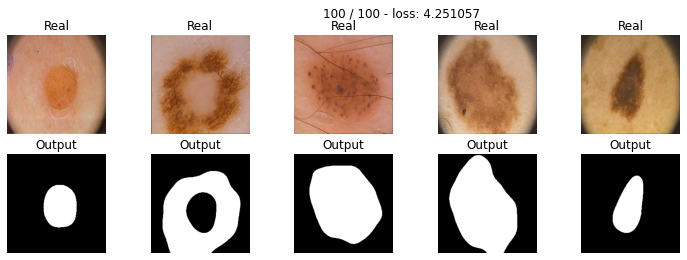

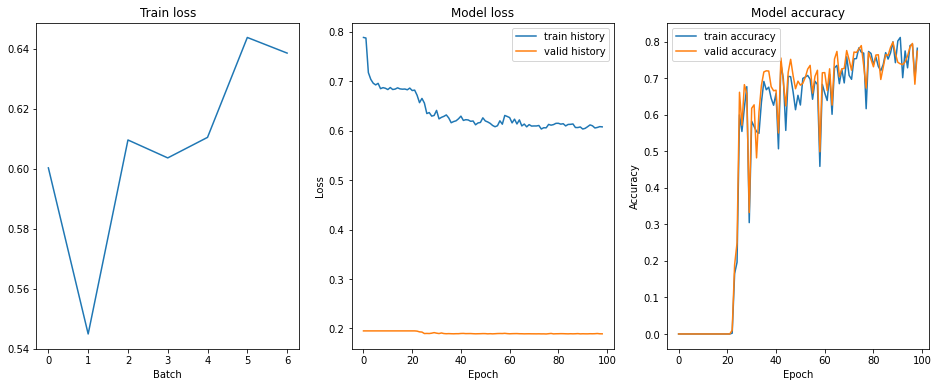

Epoch: 100
	Train Loss: 4.251
	 Val. Loss: 0.757
	Train Scores: 0.721
	 Val. Scores: 0.748


In [47]:
max_epochs = 100
optimizer = torch.optim.Adam(bce_model.parameters(), lr=1e-3)
train(bce_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [49]:
bce_segnet_accuracy = round(score_model(bce_model, iou_pytorch, data_val), 2) 
print(f'SegNet model with bce loss {bce_segnet_accuracy}')

SegNet model with bce loss 0.72



## Additional Loss Function

**1. Dice coefficient:** 

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$


$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$



In [21]:
def dice_loss(y_pred, y_real):
    smooth = 1e-8
    y_pred = torch.sigmoid(y_pred)
    intersection = 2*(y_real*y_pred).sum()
    prob = (y_real + y_pred).sum()
    num = intersection + smooth 
    den =  (prob + smooth)**(-1)
    res = 1 - (den * num)
    return res 

## SegNet with dice_loss


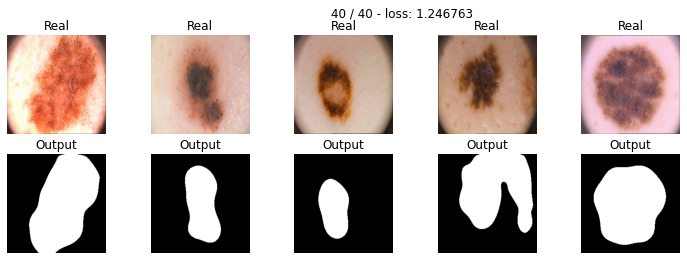

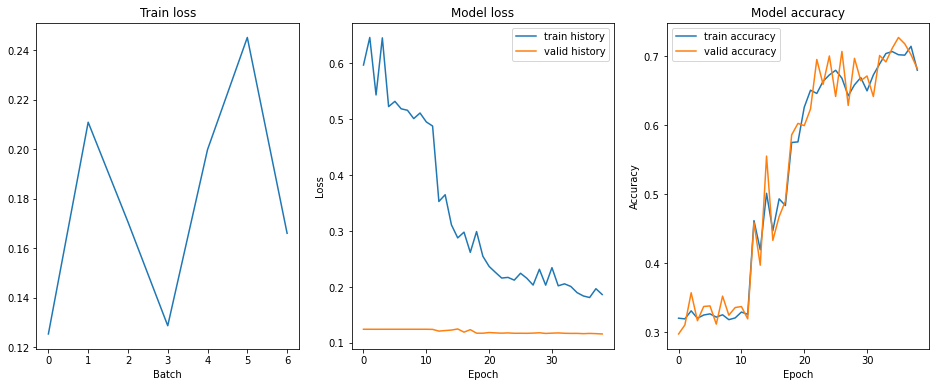

Epoch: 40
	Train Loss: 1.247
	 Val. Loss: 0.470
	Train Scores: 0.684
	 Val. Scores: 0.725


In [51]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [52]:
dice_segnet_accuracy = round(score_model(model_dice, iou_pytorch, data_val),2)
print(f'SegNet model with bce loss {dice_segnet_accuracy}')

SegNet model with bce loss 0.71


**2. Focal loss:** 
[paper](https://arxiv.org/pdf/1708.02002.pdf) 


$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$


$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$



$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$\gamma=2$.

--------------------------------------------------------------------------------


In [22]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    y_pred =  torch.sigmoid(y_pred) # hint: torch.clamp #p
    your_loss = (1 - y_pred)**gamma * y_real * torch.log(y_pred + eps) + (1-y_real) * y_pred**gamma * torch.log(1-y_pred + eps) #* y_pred**gamma
    
    return  -your_loss.mean()


## SegNet with focal_loss

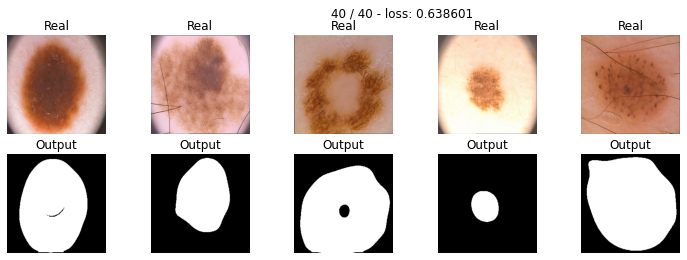

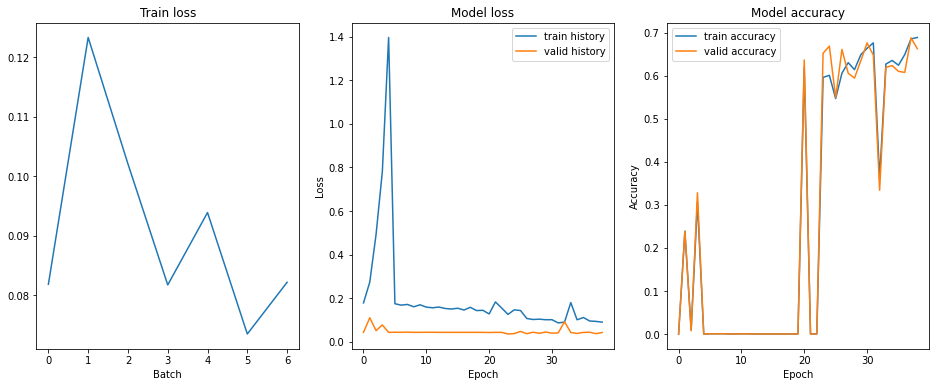

Epoch: 40
	Train Loss: 0.639
	 Val. Loss: 0.153
	Train Scores: 0.697
	 Val. Scores: 0.707


In [54]:
model_focal = SegNet().to(device)

max_epochs = 40
optimizer = optim.Adam(model_focal.parameters())
train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

In [55]:
focal_segnet_accuracy = round(score_model(model_focal, iou_pytorch, data_val), 2)
print(f'SegNet model with focal loss {focal_segnet_accuracy}')

SegNet model with focal loss 0.71




## [BONUS Tasks] 


* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)


In [23]:
def tversky_loss(y_pred, y_real, alpha=1e-8, beta=0.65):
    # References: https://arxiv.org/abs/1706.05721
    y_pred =  torch.sigmoid(y_pred)
    yy_pred = y_pred.flatten()
    yy_real = y_real.flatten()  
    true_pos = torch.sum(yy_real * yy_pred)
    false_neg = torch.sum(yy_real * (1 - yy_pred))
    false_pos = torch.sum((1 - yy_real) * yy_pred)
    res = (true_pos + alpha)/(true_pos + beta * false_neg + (1 - beta) * false_pos + alpha)
    return 1-res

## SegNet with tversky_loss

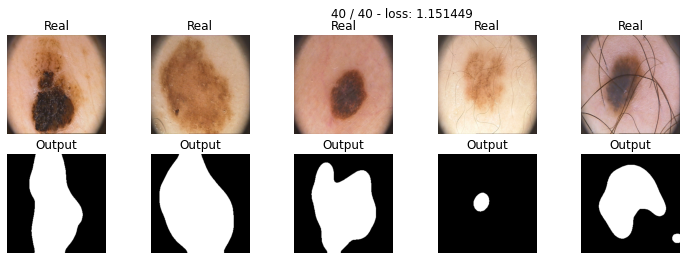

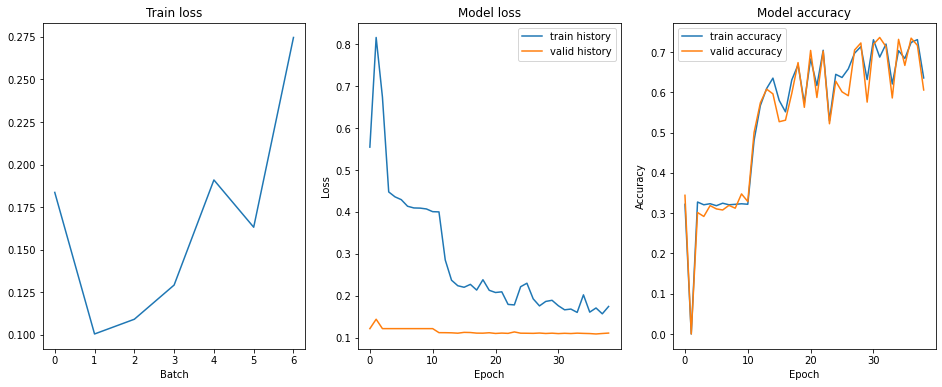

Epoch: 40
	Train Loss: 1.151
	 Val. Loss: 0.446
	Train Scores: 0.691
	 Val. Scores: 0.684


In [57]:
model_tversky = SegNet().to(device)

max_epochs = 40
optimizer = optim.Adam(model_tversky.parameters())
train(model_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val)

In [58]:
tversky_segnet_accuracy = round(score_model(model_tversky, iou_pytorch, data_val), 2)
print(f'SegNet model with bce loss {tversky_segnet_accuracy}')

SegNet model with bce loss 0.68



# U-Net 

**U-Net** [paper](https://arxiv.org/abs/1505.04597) 

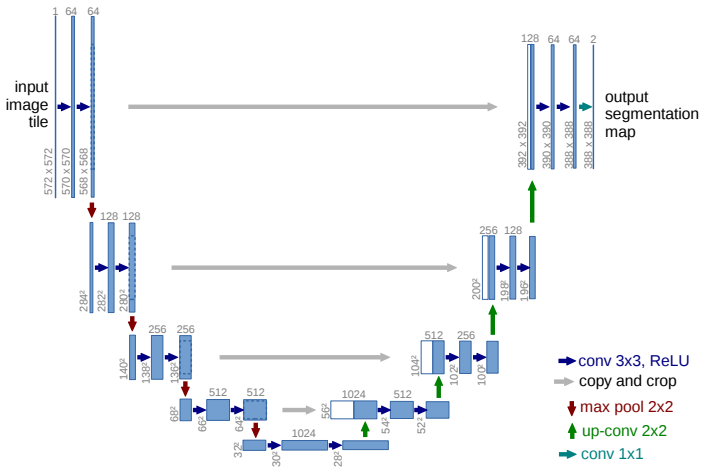

*Skip-connections*

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [24]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        
        self.enc_conv0 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU()
        ) # 256 -> 128
        self.pool0 = nn.MaxPool2d(3, 2, padding=1) #kernel_size=2, stride=2
           # 256 -> 128
        self.enc_conv1 = nn.Sequential(
                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(3, 2, padding=1) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(3, 2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(3, 2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) #nn.Upsample(scale_factor=2, mode='nearest') #nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 16 -> 32 #(16 +2*1 - 1)+1
        self.dec_conv0 = nn.Sequential(
                    nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) #nn.Upsample(scale_factor=2, mode='nearest') #nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                    nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) #nn.Upsample(scale_factor=2, mode='nearest') #nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                    nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # nn.Upsample(scale_factor=2, mode='nearest') # nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1),
                    nn.ReLU()
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        pooled_e0 = self.pool0(e0)

        e1 = self.enc_conv1(pooled_e0)
        pooled_e1 = self.pool1(e1)

        e2 = self.enc_conv2(pooled_e1)
        pooled_e2 = self.pool2(e2)

        e3 = self.enc_conv3(pooled_e2)
        pooled_e3 = self.pool3(e3)
        
        # bottleneck
        b = self.bottleneck_conv(pooled_e3)

        # decoder
        d0 = self.upsample0(b)
        d0_1 = torch.cat([d0, e3], dim=1)
        upsampled_d0 = self.dec_conv0(d0_1)
        
        d1 = self.upsample1(upsampled_d0)
        d1_1 = torch.cat([d1, e2], dim=1)
        upsampled_d1 = self.dec_conv1(d1_1)

        d2 = self.upsample2(upsampled_d1)
        d2_1 = torch.cat([d2, e1], dim=1)
        upsampled_d2 = self.dec_conv2(d2_1)
        
        d3 =  self.upsample3(upsampled_d2)
        d3_1 = torch.cat([d3, e0], dim=1)
        upsampled_d3 = self.dec_conv3(d3_1) # no activation
        
        return upsampled_d3

## UNet with bce_loss

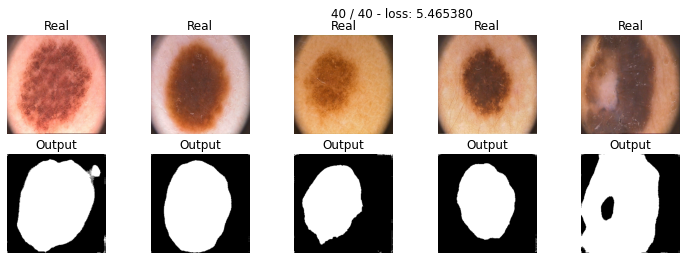

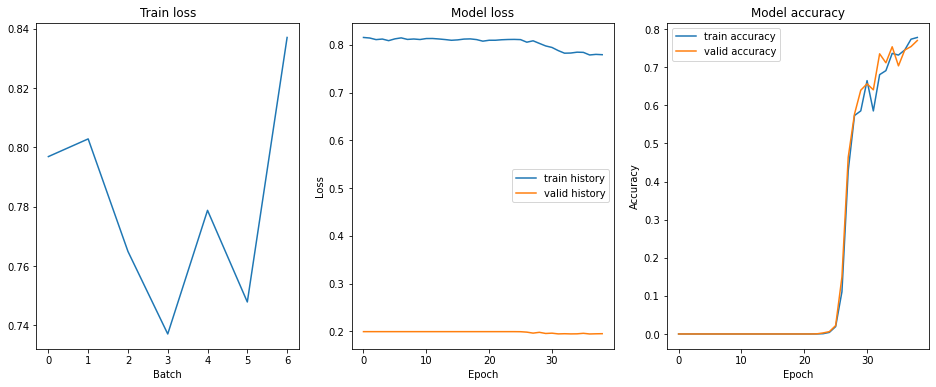

Epoch: 40
	Train Loss: 5.465
	 Val. Loss: 0.778
	Train Scores: 0.792
	 Val. Scores: 0.794


In [61]:
bce_unet_model = UNet().to(device)
epochs = 40
optimizer = optim.Adam(bce_unet_model.parameters(), lr=1e-5)
train(bce_unet_model, optimizer, bce_loss, epochs, data_tr, data_val)

In [62]:
bce_unet_accuracy = round(score_model(bce_unet_model, iou_pytorch, data_val),2)
print(f'UNet model with bce loss {bce_unet_accuracy}')

UNet model with bce loss 0.76


## UNet with dice_loss

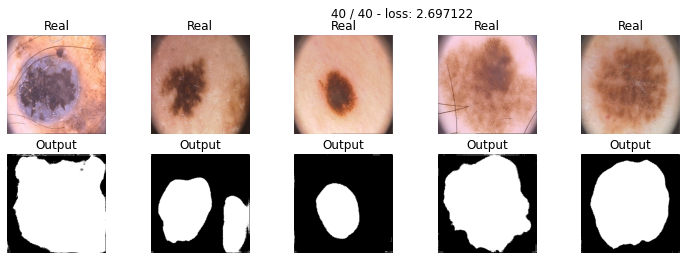

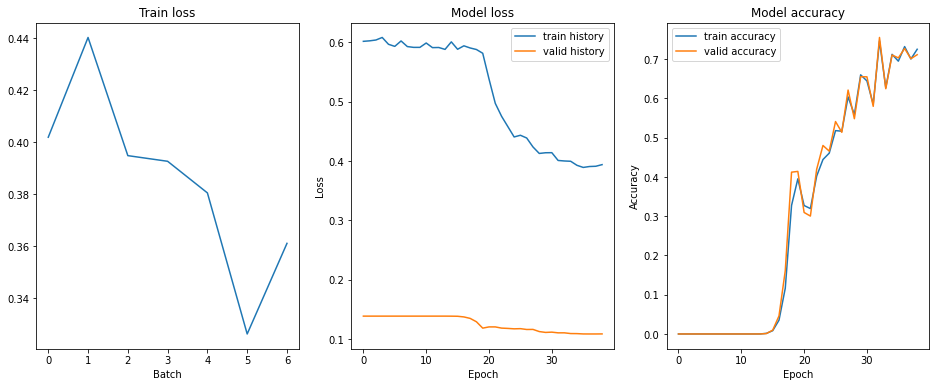

Epoch: 40
	Train Loss: 2.697
	 Val. Loss: 0.435
	Train Scores: 0.777
	 Val. Scores: 0.750


In [63]:
dice_unet_model = UNet().to(device)

max_epochs = 40
optimizer = optim.Adam(dice_unet_model.parameters(), lr=1e-5) 
train(dice_unet_model, optimizer, dice_loss, max_epochs, data_tr, data_val)

In [64]:
dice_unet_accuracy = round(score_model(dice_unet_model, iou_pytorch, data_ts), 2)
print(f'UNet model with dice loss {dice_unet_accuracy}')

UNet model with dice loss 0.77


## UNet with focal_loss

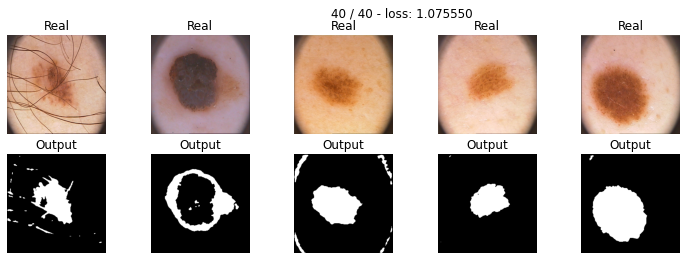

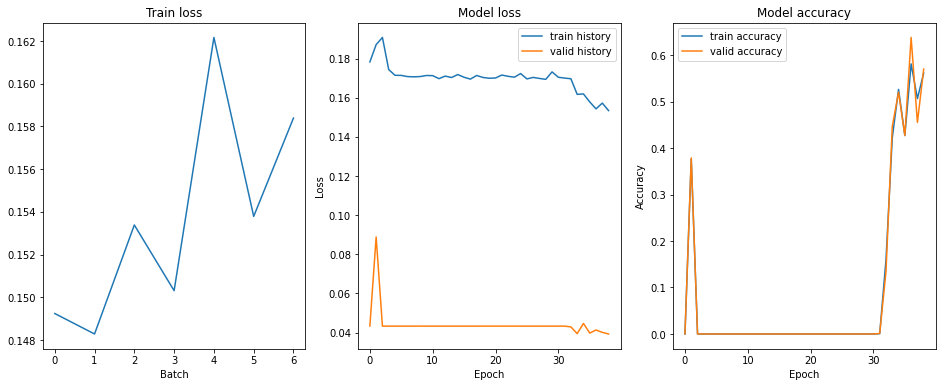

Epoch: 40
	Train Loss: 1.076
	 Val. Loss: 0.158
	Train Scores: 0.609
	 Val. Scores: 0.654


In [25]:
focal_unet_model = UNet().to(device)
max_epochs = 40
optimizer = optim.Adam(focal_unet_model.parameters())
train(focal_unet_model, optimizer, focal_loss, max_epochs, data_tr, data_val)

In [26]:
focal_unet_accuracy = round(score_model(focal_unet_model, iou_pytorch, data_ts), 2)
print(f'UNet model with focal loss {focal_unet_accuracy}')

UNet model with focal loss 0.61


## UNet with tversky_loss

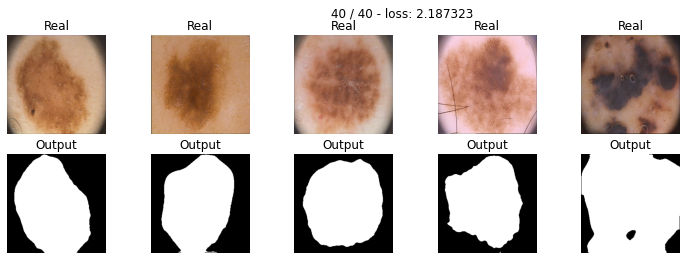

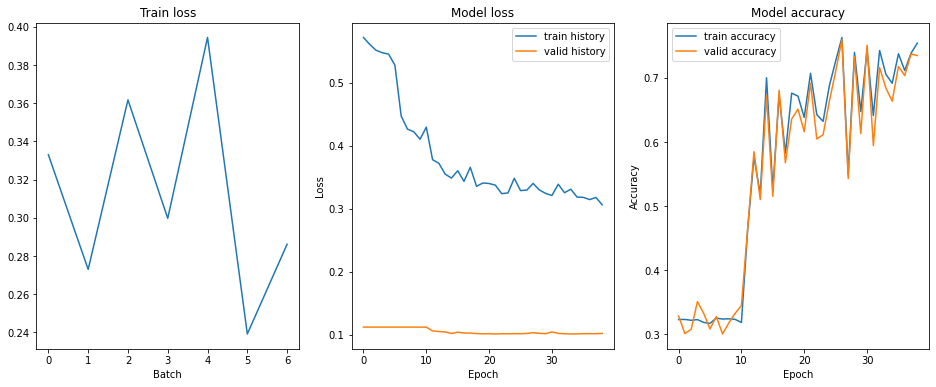

Epoch: 40
	Train Loss: 2.187
	 Val. Loss: 0.406
	Train Scores: 0.765
	 Val. Scores: 0.757


In [67]:
tversky_unet_model = UNet().to(device)
max_epochs = 40
optimizer = optim.Adam(tversky_unet_model.parameters(), lr=1e-4)
train(tversky_unet_model, optimizer, tversky_loss, max_epochs, data_tr, data_val)

In [68]:
tversky_unet_accuracy = round(score_model(tversky_unet_model, iou_pytorch, data_ts), 2)
print(f'UNet model with tversky loss {tversky_unet_accuracy}')

UNet model with tversky loss 0.76



 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)


In [27]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        
        self.enc_conv0 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU()
        ) # 256 -> 128
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) #kernel_size=2, stride=2
           # 256 -> 128
        self.enc_conv1 = nn.Sequential(
                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU()
        )
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU()
        )
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU()
        )
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 16 -> 32 #(16 +2*1 - 1)+1
        self.dec_conv0 = nn.Sequential(
                    nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                    nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                    nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1),
                    nn.BatchNorm2d(1),
                    nn.ReLU()
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        pooled_e0 = self.pool0(e0)
        e1 = self.enc_conv1(pooled_e0)
        pooled_e1 = self.pool1(e1)
        e2 = self.enc_conv2(pooled_e1)
        pooled_e2 = self.pool2(e2)
        e3 = self.enc_conv3(pooled_e2)
        pooled_e3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(pooled_e3)

        # decoder
        d0 = self.upsample0(b)
        d0_1 = torch.cat([d0, e3], dim=1)
        upsampled_d0 = self.dec_conv0(d0_1)
      
        d1 = self.upsample1(upsampled_d0)
        d1_1 = torch.cat([d1, e2], dim=1)
        upsampled_d1 = self.dec_conv1(d1_1)
      
        d2 = self.upsample2(upsampled_d1)
        d2_1 = torch.cat([d2, e1], dim=1)
        upsampled_d2 = self.dec_conv2(d2_1)
     
        d3 =  self.upsample3(upsampled_d2)
        d3_1 = torch.cat([d3, e0], dim=1)
        upsampled_d3 = self.dec_conv3(d3_1) # no activation
        
        return upsampled_d3

## UNet2 with bce_loss

In [28]:
bce_unet2_model = UNet2().to(device)

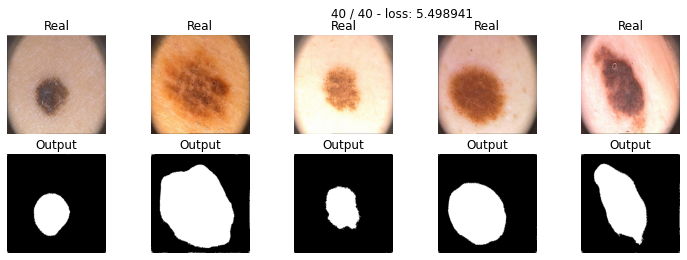

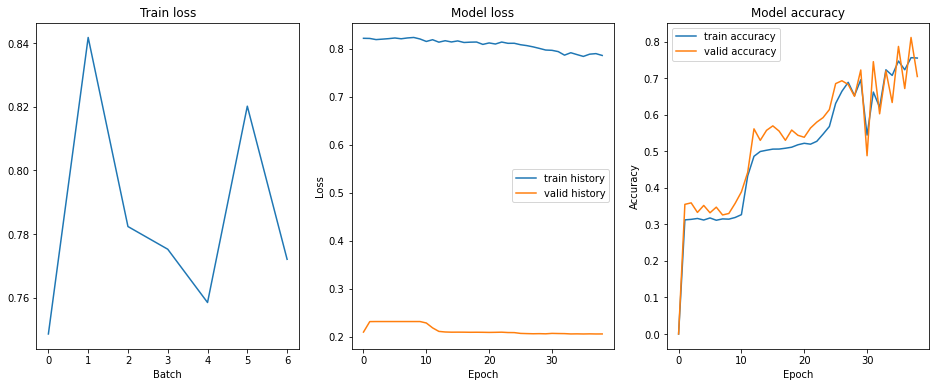

Epoch: 40
	Train Loss: 5.499
	 Val. Loss: 0.824
	Train Scores: 0.778
	 Val. Scores: 0.815


In [29]:
train(bce_unet2_model, optim.Adam(bce_unet2_model.parameters(), lr=1e-5), bce_loss, 40, data_tr, data_val)

In [30]:
bce_unet2_accuracy = round(score_model(bce_unet2_model, iou_pytorch, data_ts), 2)
print(f'UNet2 model with bce loss {bce_unet2_accuracy}')

UNet2 model with bce loss 0.74


## UNet2 with dice_loss

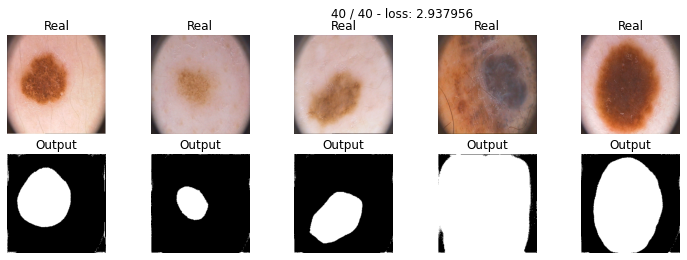

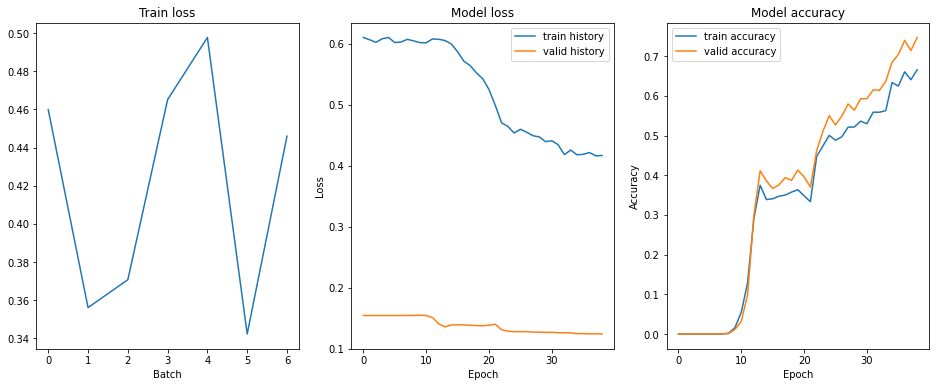

Epoch: 40
	Train Loss: 2.938
	 Val. Loss: 0.496
	Train Scores: 0.708
	 Val. Scores: 0.779


In [31]:
dice_unet2_model = UNet2().to(device)
train(dice_unet2_model, optim.Adam(dice_unet2_model.parameters(), lr=1e-5), dice_loss, 40, data_tr, data_val)

In [32]:
dice_unet2_accuracy = round(score_model(dice_unet2_model, iou_pytorch, data_ts), 2)
print(f'UNet2 model with dice loss {dice_unet2_accuracy}')

UNet2 model with dice loss 0.72


## UNet2 with focal_loss

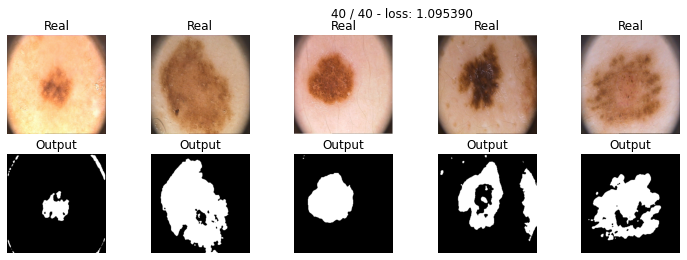

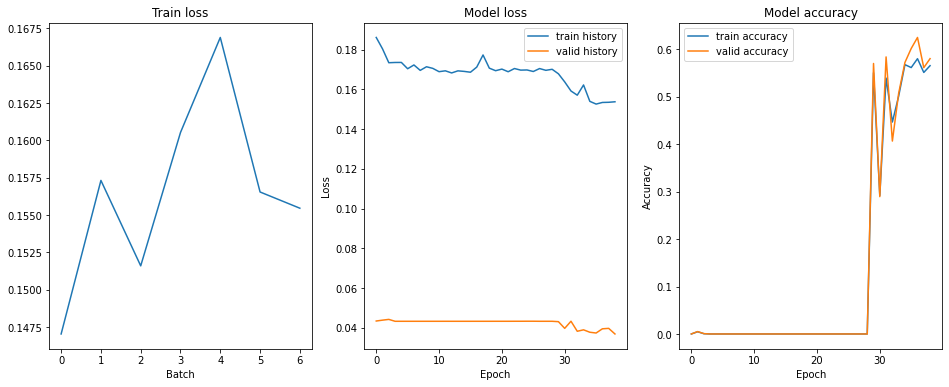

Epoch: 40
	Train Loss: 1.095
	 Val. Loss: 0.148
	Train Scores: 0.564
	 Val. Scores: 0.573


In [33]:
focal_unet2_model = UNet2().to(device)
train(focal_unet2_model, optim.Adam(focal_unet2_model.parameters()), focal_loss, 40, data_tr, data_val)

In [35]:
focal_unet2_accuracy = round(score_model(focal_unet2_model, iou_pytorch, data_ts), 2)
print(f'UNet2 model with focal loss {focal_unet2_accuracy}')

UNet2 model with focal loss 0.56


## UNet2 with tversky_loss

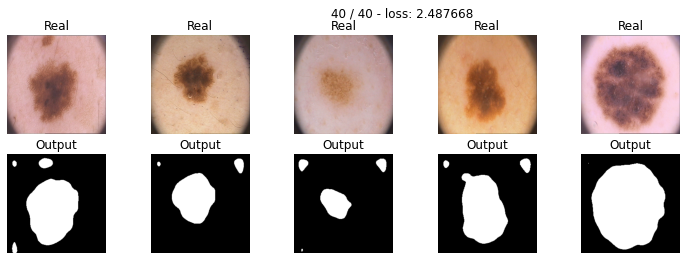

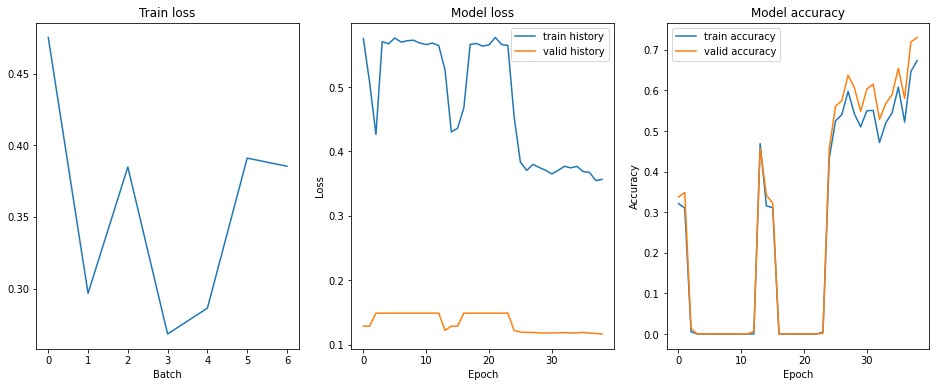

Epoch: 40
	Train Loss: 2.488
	 Val. Loss: 0.467
	Train Scores: 0.690
	 Val. Scores: 0.759


In [36]:
tversky_unet2_model = UNet2().to(device)
train(tversky_unet2_model, optim.Adam(tversky_unet2_model.parameters()), tversky_loss, 40, data_tr, data_val)

In [37]:
tversky_unet2_accuracy = round(score_model(tversky_unet2_model, iou_pytorch, data_ts), 2)
print(f'UNet2 model with tversky loss {tversky_unet2_accuracy}')

UNet2 model with tversky loss 0.72


# Results


In [39]:
import pandas as pd

data = [['BCE_Loss', bce_segnet_accuracy, bce_unet_accuracy, bce_unet2_accuracy],\
        ['Dice_Loss', dice_segnet_accuracy, dice_unet_accuracy, dice_unet2_accuracy],\
        ['Focal_Loss', focal_segnet_accuracy, focal_unet_accuracy, focal_unet2_accuracy],
        ['Tversky_Loss', tversky_segnet_accuracy, tversky_unet_accuracy, tversky_unet2_accuracy]]
result = pd.DataFrame(data, columns = ['Losses', 'SegNet', 'UNet', 'UNet2'])

In [40]:
result

,Losses,SegNet,UNet,UNet2
0,BCE_Loss,0.72,0.76,0.74
1,Dice_Loss,0.71,0.77,0.72
2,Focal_Loss,0.71,0.61,0.56
3,Tversky_Loss,0.68,0.76,0.72
